2022학년도 2학기, 임창원 교수님 '이미지분석을위한딥러닝' 과목에서 진행한 프로젝트입니다. Ipynb파일로 진행한 만큼  결과가 산개해있습니다. 때문에 과제의 일환으로 함께 제출하였던 동명의 pdf파일을 첨부하였습니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

"understanding_cloud_organization" 폴더가 있는 디렉토리를 지정해 주세요.

In [5]:
Hymynameis = "/tf"

## preparation

In [6]:
import tensorflow as tf #텐서~~플로우~~

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from skimage.data import imread
import matplotlib.pyplot as plt
import cv2
import json

import multiprocessing

import albumentations as albu

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc

from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.layers import MaxPooling2D, Activation
from tensorflow.keras.layers import concatenate, Lambda, Dropout, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import os, glob

from tqdm import tqdm_notebook as tqdm


In [8]:
def np_resize(img, input_shape,graystyle=False):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """

    height, width = input_shape
    resized_img = cv2.resize(img, (width, height))
    
    # keep dimension
    if graystyle:
        resized_img = resized_img[..., None]
        
    return resized_img

def mask2rle(img):
    '''
    img: a mask image, numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    img.T.flatten()
    image(width x height x channel), 
    from width -> height -> channel flatten a one dimension array 
    
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])  # add 0 to the beginning and end of array
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

## Preprocessing and EDA

In [9]:
train_images = os.listdir(Hymynameis+'/understanding_cloud_organization/train_images')
test_images = os.listdir(Hymynameis+'/understanding_cloud_organization/test_images')

- Split Image_Label into ImageId and Label
- Add `hasMask` column

In [10]:
train_df = pd.read_csv(Hymynameis+'/understanding_cloud_organization/train.csv')
train_df.head()

# Split Image_Label into ImageId and Label
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x : x.split('_')[0])
train_df['Label'] = train_df['Image_Label'].apply(lambda x : x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

In [11]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)

In [12]:
mask_count_df.head()

,ImageId,hasMask
821,24dd99c.jpg,4
1885,562f80a.jpg,4
3260,944f10b.jpg,4
1872,55b539f.jpg,4
4464,cdf7242.jpg,4


In [13]:
submission_df = pd.read_csv(Hymynameis+'/understanding_cloud_organization/sample_submission.csv')
submission_df['ImageId'] = submission_df['Image_Label'].apply(lambda x : x.split('_')[0])
test_images = pd.DataFrame(submission_df['ImageId'].unique(), columns=['ImageId'])

In [14]:
test_images.head()

,ImageId
0,002f507.jpg
1,0035ae9.jpg
2,0038327.jpg
3,004f759.jpg
4,005ba08.jpg


## One-hot encoding classed

In [15]:
train_ohe_df = train_df[~train_df['EncodedPixels'].isnull()]
classes = train_ohe_df['Label'].unique()
train_ohe_df = train_ohe_df.groupby('ImageId')['Label'].agg(set).reset_index()
for class_name in classes:
    train_ohe_df[class_name] = train_ohe_df['Label'].map(lambda x: 1 if class_name in x else 0)
img_to_ohe_vector = {img: vec for img, vec in zip(train_ohe_df['ImageId'], train_ohe_df.iloc[:, 2:].values)}

## Stratified split into train and val

In [16]:
train_idx, val_idx = train_test_split(mask_count_df.index, 
                                      random_state=24,
                                      stratify = train_ohe_df['Label'].map(lambda x: str(sorted(list(x)))),# sorting present classes in lexicographical order, just to be sure
                                      test_size = 0.2)

In [17]:
print('train length:',len(train_idx))
print('val length:',len(val_idx))

train length: 4436
val length: 1110


## Data Generator

In [18]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=Hymynameis+'/understanding_cloud_organization/train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=42, shuffle=True, graystyle=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.graystyle = graystyle
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape).astype(np.float32)
                
            
            # Store samples
            X[i,] = img.astype(np.float32)

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes))
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes))
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks.astype(np.float32)

        return y
    
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5),
            # albu.RandomRotate90(p=1),
            # albu.RandomBrightness(),
            #albu.ElasticTransform(p=1,alpha=120,sigma=120*0.05,alpha_affine=120*0.03),
            albu.GridDistortion(p=0.5)])
            #albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5),
            #albu.ShiftScaleRotate(scale_limit=0.5,rotate_limit=30, shift_limit=0.1, p=1, border_mode=0)])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch
    
    def get_labels(self):
        if self.shuffle:
            images_current = self.list_IDs[:self.len * self.batch_size]
            labels = [img_to_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

Generator instances

In [27]:
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0005  # 이거 튜닝하는게 제일 중요.
HEIGHT = 384
WIDTH = 576
IMG_SIZE = (HEIGHT, WIDTH)
CHANNELS = 3
ES_PATIENCE = 3
RLROP_PATIENCE = 2
DECAY_DROP = 0.5
N_CLASSES = train_df['Label'].nunique()


In [28]:
train_generator = DataGenerator(train_idx, 
                                df=mask_count_df, 
                                target_df=train_df, 
                                batch_size=BATCH_SIZE,
                                reshape=(HEIGHT, WIDTH),
                                augment=True,
                                graystyle=False,
                                shuffle = True,
                                n_channels=CHANNELS,
                                n_classes=N_CLASSES)

train_eval_generator = DataGenerator(train_idx, 
                              df=mask_count_df, 
                              target_df=train_df, 
                              batch_size=BATCH_SIZE, 
                              reshape=(HEIGHT, WIDTH),
                              augment=False,
                              graystyle=False,
                              shuffle = False,
                              n_channels=CHANNELS,
                              n_classes=N_CLASSES)

val_generator = DataGenerator(val_idx, 
                              df=mask_count_df, 
                              target_df=train_df, 
                              batch_size=BATCH_SIZE, 
                              reshape=(HEIGHT, WIDTH),
                              augment=False,
                              graystyle=False,
                              shuffle = False,
                              n_channels=CHANNELS,
                              n_classes=N_CLASSES)


## Model Architecture

### HRNet

In [ ]:
import tensorflow as tf
import numpy as np

def hr_basic_block(x, n_feature, stride_size = (1, 1), shortcut = False, **kwargs):
    out = tf.keras.layers.Conv2D(n_feature, 3, strides = stride_size, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    out = tf.keras.layers.Conv2D(n_feature, 3, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    
    if shortcut:
        x = tf.keras.layers.Conv2D(n_feature, 1, strides = stride_size, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
        x = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(x)
        out = tf.keras.layers.Add()([out, x])
    else:
        out = tf.keras.layers.Add()([out, x])
    
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    return out

def hr_bottleneck_block(x, n_feature, stride_size = (1, 1), shortcut = False, expansion = 4, **kwargs):
    n_decode_filter = n_feature // expansion
    out = tf.keras.layers.Conv2D(n_decode_filter, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    out = tf.keras.layers.Conv2D(n_decode_filter, 3, strides = stride_size, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    out = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
   
    if shortcut:
        x = tf.keras.layers.Conv2D(n_feature, 1, strides = stride_size, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
        x = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(x)
        out = tf.keras.layers.Add()([out, x])
    else:
        out = tf.keras.layers.Add()([out, x])
    
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    return out

def hr_transition_block(x, n_feature, **kwargs):
    if not isinstance(x, list):
        x = [x]
    if isinstance(n_feature, int):
        n_feature = [n_feature * (2 ** pow) for pow in range(len(x) + 1)]

    out = []
    for index, _n_feature in enumerate(n_feature):
        if (index + 1) == len(n_feature):
            feature = x[index - 1]
            stride_size = (2, 2)
        else:
            feature = x[index]
            stride_size = (1, 1)
        o = tf.keras.layers.Conv2D(_n_feature, 3, strides = stride_size, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(feature)
        o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
        o = tf.keras.layers.Activation(tf.keras.activations.relu)(o)
        out.append(o)
    return out

def hr_module(x, n_branch = 4, shortcut = False, **kwargs):
    if not isinstance(x, list):
        x = [x]
    n_feature = [tf.keras.backend.int_shape(_x)[-1] for _x in x]

    out = list(x)
    # branch
    for _ in range(n_branch):
        for index, _n_feature in enumerate(n_feature):
            out[index] = hr_basic_block(out[index], _n_feature, shortcut = shortcut, **kwargs)

    # fuse
    outs = []
    for index, _n_feature in enumerate(n_feature):
        _out = []
        for seq, o in enumerate(out):
            if seq < index:
                for k in range(index - seq):
                    o = tf.keras.layers.Conv2D(_n_feature, 3, strides = 2, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(o)
                    o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
                    if k != (index - seq - 1):
                        o = tf.keras.layers.Activation(tf.keras.activations.relu)(o)
            elif seq == index:
                pass
            else: #index < seq
                o = tf.keras.layers.Conv2D(_n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(o)
                o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
                upsample_size = [2 ** (seq - index)] * 2
                o = tf.keras.layers.UpSampling2D(upsample_size, interpolation = "bilinear")(o)
            _out.append(o)
        _out = tf.keras.layers.Add()(_out)
        _out = tf.keras.layers.Activation(tf.keras.activations.relu)(_out)
        outs.append(_out)
    return outs

def object_attention_context(feature, prob, scale = 1):
    feature = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(feature)[-1]])(feature)
    feature = tf.keras.layers.Permute([2, 1])(feature)
    prob = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(prob)[-1]])(prob)
    prob = tf.keras.activations.softmax(prob * scale, axis = -2)
    context = tf.keras.layers.Dot([2, 1])([feature, prob]) #batch x featrue ch x prob ch
    context = tf.keras.backend.expand_dims(context, axis = -2) #batch x featrue ch x 1 x prob ch
    return context

def object_attention(feature, prob, n_feature = 256, scale = 1, **kwargs):
    if 1 < scale:
        feature = tf.keras.layers.MaxPooling2D((scale, scale), padding = "same")(feature)
    proxy_context = object_attention_context(feature, prob, scale)

    query = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(feature)
    query = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(query)
    query = tf.keras.layers.Activation(tf.keras.activations.relu)(query)
    query = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(query)
    query = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(query)
    query = tf.keras.layers.Activation(tf.keras.activations.relu)(query)
    query = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(query)[-1]])(query)

    key = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(proxy_context)
    key = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(key)
    key = tf.keras.layers.Activation(tf.keras.activations.relu)(key)
    key = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(key)
    key = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(key)
    key = tf.keras.layers.Activation(tf.keras.activations.relu)(key)
    key = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(key)[-1]])(key)
    key = tf.keras.layers.Permute([2, 1])(key)

    value = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(proxy_context)
    value = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(value)
    value = tf.keras.layers.Activation(tf.keras.activations.relu)(value)
    value = tf.keras.layers.Reshape([-1, tf.keras.backend.int_shape(value)[-1]])(value)

    sim = tf.keras.layers.Dot([2, 1])([query, key])
    sim = sim * (n_feature ** -0.5)
    sim = tf.keras.activations.softmax(sim)

    context = tf.keras.layers.Dot([2, 1])([sim, value])
    context = tf.keras.layers.Reshape(tf.keras.backend.int_shape(feature)[-3:-1] + (n_feature,))(context)
    context = tf.keras.layers.Conv2D(tf.keras.backend.int_shape(feature)[-1], 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(context)
    context = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(context)
    context = tf.keras.layers.Activation(tf.keras.activations.relu)(context)
    
    if 1 < scale:
        context = tf.keras.layers.UpSampling2D((scale, scale))(context)
    return context

def ocr_module(feature, prob, n_feature = 512, n_attention_feature = 256, dropout_rate = 0.05, scale = 1, **kwargs):
    context = object_attention(feature, prob, n_attention_feature, scale, **kwargs)
    out = tf.keras.layers.Concatenate(axis = -1)([feature, context])
    out = tf.keras.layers.Conv2D(n_feature, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
    out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
    out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
    out = tf.keras.layers.Dropout(dropout_rate)(out)
    return out

def hrnet_v2(x, n_class = 35, include_top = True, n_channel = 48, n_module = [1, 4, 3], n_branch = [2, 3, 4], stage1_channel = 64, stage1_module = 1, ocr_feature_channel = 512, ocr_attention_channel = 256, ocr_dropout_rate = 0.05, ocr_scale = 1, mode = "ocr", **kwargs):
    if mode not in ("seg", "clsf", "ocr"):
        raise ValueError("unknown mode '{0}'".format(mode))
    if isinstance(n_channel, int):
        n_channel = [n_channel * (2 ** pow) for pow in range(4)]
    if isinstance(n_module, int):
        n_module = [n_module] * 3
    if isinstance(n_branch, int):
        n_branch = [n_branch] * 3

    if not isinstance(x, list):
        #Stem
        out = tf.keras.layers.Conv2D(64, 3, strides = 2, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x)
        out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
        out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
        out = tf.keras.layers.Conv2D(64, 3, strides = 2, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
        out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
        out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
        
        #Stage1
        out = hr_bottleneck_block(out, stage1_channel, shortcut = True, **kwargs)
        for _ in range(1, stage1_module):
            out = hr_bottleneck_block(out, stage1_channel, **kwargs)
    else:
        x = list(x)
        shape = tf.keras.backend.int_shape(x[0])[-3:-1]
        for index in range(len(x)):
            o = tf.keras.layers.Conv2D(n_channel[index], 3, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(x[index])
            o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
            o = tf.keras.layers.Activation(tf.keras.activations.relu)(o)
            if 0 < index:
                target_size = np.divide(shape, 2 ** index).astype(np.int32)
                o = tf.image.resize(o, target_size, method = "bilinear")
            x[index] = o

    #Stage2: transition -> branch -> fuse x2
    # transition
    if not isinstance(x, list):
        out = hr_transition_block(out, n_channel[:2], **kwargs)
    else:
        out = x[:2]
    # branch & fuse
    for _ in range(n_module[0]):
        out = hr_module(out, n_branch = n_branch[0], shortcut = False, **kwargs)

    #Stage3: transition -> branch -> fuse x3
    # transition
    if not isinstance(x, list):
        out = hr_transition_block(out, n_channel[:3], **kwargs)
    else:
        out = out + x[2:3]
    # branch & fuse
    for _ in range(n_module[1]):
        out = hr_module(out, n_branch = n_branch[1], shortcut = False, **kwargs)

    #Stage4: transition -> branch -> fuse x4
    # transition
    if not isinstance(x, list):
        out = hr_transition_block(out, n_channel[:4], **kwargs)
    else:
        out = out + x[3:4]
    # branch & fuse
    for _ in range(n_module[2]):
        out = hr_module(out, n_branch = n_branch[2], shortcut = False, **kwargs)

    if mode != "clsf":
        #Concatenate
        for index in range(1, len(out)):
            upsample_size = np.divide(tf.keras.backend.int_shape(out[0])[-3:-1], tf.keras.backend.int_shape(out[index])[-3:-1]).astype(np.int32)
            out[index] = tf.keras.layers.UpSampling2D(upsample_size, interpolation = "bilinear")(out[index])
        out = tf.keras.layers.Concatenate(axis = -1)(out)
    else:
        #Add
        o = hr_bottleneck_block(out[0], tf.keras.backend.int_shape(out[0])[-1], **kwargs)
        for _o in out[1:]:
            ch = tf.keras.backend.int_shape(_o)[-1]
            _o = hr_bottleneck_block(_o, ch, **kwargs)
            o = tf.keras.layers.Conv2D(ch, 3, strides = 2, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(o)
            o = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(o)
            o = tf.keras.layers.Activation(tf.keras.activations.relu)(o)
            o = tf.keras.layers.Add()([o, _o])
        out = o

    if include_top:
        if mode != "clsf":
            out_aux = tf.keras.layers.Conv2D(tf.keras.backend.int_shape(out)[-1], 1, use_bias = True, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
            out_aux = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out_aux)
            out_aux = tf.keras.layers.Activation(tf.keras.activations.relu)(out_aux)
            out_aux = tf.keras.layers.Conv2D(n_class, 1, use_bias = True, kernel_initializer = "he_normal", name = "logits", **kwargs)(out_aux)
            if mode == "ocr":
                out = tf.keras.layers.Conv2D(ocr_feature_channel, 3, padding = "same", use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
                out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
                out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
                out = ocr_module(out, out_aux, ocr_feature_channel, ocr_attention_channel, ocr_dropout_rate, ocr_scale, **kwargs)
                out = tf.keras.layers.Conv2D(n_class, 1, use_bias = True, kernel_initializer = "he_normal", name = "logits_ocr", **kwargs)(out)
            else:
                out = out_aux
        else:
            out = tf.keras.layers.Conv2D(2048, 1, use_bias = False, kernel_initializer = "he_normal", bias_initializer = "zeros")(out)
            out = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.9, epsilon = 1e-5)(out)
            out = tf.keras.layers.Activation(tf.keras.activations.relu)(out)
            out = tf.keras.layers.GlobalAveragePooling2D()(out)
            out = tf.keras.layers.Dense(n_class, use_bias = True, name = "logits")(out)
    return out

def hrnet18_v2(x, n_class = 35, include_top = True, mode = "ocr"):
    out = hrnet_v2(x, n_class, include_top, n_channel = [18, 36, 72, 144], n_module = [1, 4, 3], n_branch = [2, 3, 4], stage1_channel = 64, stage1_module = 1, ocr_feature_channel = 512, ocr_attention_channel = 256, ocr_dropout_rate = 0.05, ocr_scale = 1, mode = mode)
    return out

def hrnet32_v2(x, n_class = 35, include_top = True, mode = "ocr"):
    out = hrnet_v2(x, n_class, include_top, n_channel = [32, 64, 128, 256], n_module = [1, 4, 3], n_branch = [2, 3, 4], stage1_channel = 64, stage1_module = 1, ocr_feature_channel = 512, ocr_attention_channel = 256, ocr_dropout_rate = 0.05, ocr_scale = 1, mode = mode)
    return out

def hrnet48_v2(x, n_class = 35, include_top = True, mode = "ocr"):
    out = hrnet_v2(img_input, n_class, include_top, n_channel = [48, 94, 192, 384], n_module = [1, 4, 3], n_branch = [2, 3, 4], stage1_channel = 64, stage1_module = 1, ocr_feature_channel = 512, ocr_attention_channel = 256, ocr_dropout_rate = 0.05, ocr_scale = 1, mode = mode)
    return out

In [ ]:
x = tf.keras.layers.Input(shape = (HEIGHT, WIDTH, 3))
out = hrnet18_v2(x, n_class = 4, include_top = True, mode = "seg") #mode = seg > hrnet v2 + semantic segmentation, clsf > hrnet v2 + classifier, ocr > hrnet v2 + ocr + semantic segmentation
out = tf.keras.layers.UpSampling2D((4, 4), interpolation = "bilinear")(out)
model = tf.keras.Model(x, out)

In [ ]:
ACTIVATION = 'relu'
KERNEL_SIZE = (3, 3)
EPOCHS = 20
kernel_orig = 64
INPUT_SHAPE = (HEIGHT, WIDTH, 3)
BATCH_NORMAL = [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True] #하고싶은데를 True로 바꾸면 됨
DROPOUT = [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None] #하고싶은데에 p를 넣으면 됨. (드롭아웃 비율)

In [ ]:
def unet_bn_relu(inputs,
                 actf,
                 batch_normal = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False],
                 dropout = [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]):
    
    c11 = Conv2D(kernel_orig, KERNEL_SIZE, activation=None, padding='same')(inputs)
    if batch_normal[0] is True:
        c11 = BatchNormalization()(c11)
    c11 = Activation(actf)(c11)
    if dropout[0] is not None:
        c11 = Dropout(dropout[0])(c11)
    c12 = Conv2D(kernel_orig, KERNEL_SIZE, activation=None, padding='same')(c11)
    if batch_normal[1] is True:
        c12 = BatchNormalization()(c12)
    c12 = Activation(actf)(c12)
    if dropout[1] is not None:
        c12 = Dropout(dropout[1])(c12)
    p1 = MaxPooling2D((2, 2), strides=2)(c12)

    c21 = Conv2D(kernel_orig*2, KERNEL_SIZE, activation=None, padding='same')(p1)
    if batch_normal[2] is True:
        c21 = BatchNormalization()(c21)
    c21 = Activation(actf)(c21)
    if dropout[2] is not None:
        c21 = Dropout(dropout[2])(c21)
    c22 = Conv2D(kernel_orig*2, KERNEL_SIZE, activation=None, padding='same')(c21)
    if batch_normal[3] is True:
        c22 = BatchNormalization()(c22)
    c22 = Activation(actf)(c22)
    if dropout[3] is not None:
        c22 = Dropout(dropout[3])(c22)
    p2 = MaxPooling2D((2, 2), strides=2)(c22)

    c31 = Conv2D(kernel_orig*4, KERNEL_SIZE, activation=None, padding='same')(p2)
    if batch_normal[4] is True:
        c31 = BatchNormalization()(c31)
    c31 = Activation(actf)(c31)
    if dropout[4] is not None:
        c31 = Dropout(dropout[4])(c31)
    c32 = Conv2D(kernel_orig*4, KERNEL_SIZE, activation=None, padding='same')(c31)
    if batch_normal[5] is True:
        c32 = BatchNormalization()(c32)
    c32 = Activation(actf)(c32)
    if dropout[5] is not None:
        c32 = Dropout(dropout[5])(c32)
    p3 = MaxPooling2D((2, 2), strides=2)(c32)

    c41 = Conv2D(kernel_orig*8, KERNEL_SIZE, activation=None, padding='same')(p3)
    if batch_normal[6] is True:
        c41 = BatchNormalization()(c41)
    c41 = Activation(actf)(c41)
    if dropout[6] is not None:
        c41 = Dropout(dropout[6])(c41)
    c42 = Conv2D(kernel_orig*8, KERNEL_SIZE, activation=None, padding='same')(c41)
    if batch_normal[7] is True:
        c42 = BatchNormalization()(c42)    
    c42 = Activation(actf)(c42)
    if dropout[7] is not None:
        c42 = Dropout(dropout[7])(c42)
    p4 = MaxPooling2D((2, 2), strides=2)(c42)

    c51 = Conv2D(kernel_orig*16, KERNEL_SIZE, activation=None, padding='same')(p4)
    if batch_normal[8] is True:
        c51 = BatchNormalization()(c51)
    c51 = Activation(actf)(c51)
    if dropout[8] is not None:
        c51 = Dropout(dropout[8])(c51)
    c52 = Conv2D(kernel_orig*16, KERNEL_SIZE, activation=None, padding='same')(c51)
    if batch_normal[9] is True:
        c52 = BatchNormalization()(c52)
    c52 = Activation(actf)(c52)
    if dropout[9] is not None:
        c52 = Dropout(dropout[9])(c52)

    u6 = Conv2DTranspose(kernel_orig*8, (2, 2), strides=(2, 2))(c52)
    u6 = Concatenate()([u6, c42])
    c61 = Conv2D(kernel_orig*8, KERNEL_SIZE, activation=None, padding='same')(u6)
    if batch_normal[10] is True:
        c61 = BatchNormalization()(c61)
    c61 = Activation(actf)(c61)
    if dropout[10] is not None:
        c61 = Dropout(dropout[10])(c61)
    c62 = Conv2D(kernel_orig*8, KERNEL_SIZE, activation=None, padding='same')(c61)
    if batch_normal[11] is True:
        c62 = BatchNormalization()(c62)
    c62 = Activation(actf)(c62)
    if dropout[11] is not None:
        c62 = Dropout(dropout[11])(c62)

    u7 = Conv2DTranspose(kernel_orig*4, (2, 2), strides=(2, 2))(c62)
    u7 = Concatenate()([u7, c32])
    c71 = Conv2D(kernel_orig*4, KERNEL_SIZE, activation=None, padding='same')(u7)
    if batch_normal[12] is True:
        c71 = BatchNormalization()(c71)
    c71 = Activation(actf)(c71)
    if dropout[12] is not None:
        c71 = Dropout(dropout[12])(c71)
    c72 = Conv2D(kernel_orig*4, KERNEL_SIZE, activation=None, padding='same')(c71)
    if batch_normal[13] is True:
        c72 = BatchNormalization()(c72)
    c72 = Activation(actf)(c72)
    if dropout[13] is not None:
        c72 = Dropout(dropout[13])(c72)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2))(c72)
    u8 = Concatenate()([u8, c22])
    c81 = Conv2D(kernel_orig*2, KERNEL_SIZE, activation=None, padding='same')(u8)
    if batch_normal[14] is True:
        c81 = BatchNormalization()(c81)
    c81 = Activation(actf)(c81)
    if dropout[14] is not None:
        c81 = Dropout(dropout[14])(c81)
    c82 = Conv2D(kernel_orig*2, KERNEL_SIZE, activation=None, padding='same')(c81)
    c82 = BatchNormalization()(c82)
    if batch_normal[15] is True:
        c82 = BatchNormalization()(c82)
    c82 = Activation(actf)(c82)
    if dropout[15] is not None:
        c82 = Dropout(dropout[15])(c82)

    u9 = Conv2DTranspose(kernel_orig, (2, 2), strides=(2, 2))(c82)
    u9 = Concatenate()([u9, c12])
    c91 = Conv2D(kernel_orig, KERNEL_SIZE, activation=None, padding='same')(u9)
    if batch_normal[16] is True:
        c91 = BatchNormalization()(c91)
    c91 = Activation(actf)(c91)
    if dropout[16] is not None:
        c91 = Dropout(dropout[16])(c91)
    c92 = Conv2D(kernel_orig, KERNEL_SIZE, activation=None, padding='same')(c91)
    if batch_normal[17] is True:
        c92 = BatchNormalization()(c92)
    c92 = Activation(actf)(c92)
    if dropout[17] is not None:
        c92 = Dropout(dropout[17])(c92)


    outputs = Conv2D(4, (1, 1), activation=None) (c92)
    
    return outputs

In [ ]:
model = unet_bn_relu(input_shape=(HEIGHT, WIDTH, 3), actf = ACTIVATION, batch_normal = BATCH_NORMAL, dropout = DROPOUT)
model.summary()

### U-Net (with pretrained backbone)

In [21]:
SM_FRAMEWORK=tf.keras

In [29]:
!pip install segmentation_models
import segmentation_models as sm

In [30]:
sm.set_framework('tf.keras')

In [31]:
BACKBONE = 'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [32]:
model = sm.Unet(BACKBONE,
                classes=N_CLASSES, 
                input_shape=(HEIGHT,WIDTH,CHANNELS), 
                activation='sigmoid')

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 576, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 385, 577, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 192, 288, 32  864         ['Conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Training

In [37]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + 3*dice_loss(y_true, y_pred))/4

In [38]:
earlystopping = EarlyStopping(monitor='val_loss', 
                             mode='min', 
                             patience=ES_PATIENCE,
                             restore_best_weights=True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              mode='min',
                              patience=RLROP_PATIENCE,
                              factor=DECAY_DROP,
                              min_lr=1e-6,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath = Hymynameis+'/understanding_cloud_organization/hrnet.h5', save_best_only=True)

metric_list = [dice_coef]
callback_list = [earlystopping, reduce_lr, checkpoint]
optimizer = Adam(lr = LEARNING_RATE)

model.compile(optimizer=optimizer, 
              loss=bce_dice_loss, 
              metrics=metric_list)



In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=callback_list,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50
277/277 [==============================] - ETA: 0s - loss: 0.5087 - dice_coef: 0.4596

Model 4-1 : U-Net (Encoder : VGG19)

In [80]:
def draw_convex_hull(mask, mode='convex'):
    img = np.zeros(mask.shape)
    contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        if mode=='rect': # simple rectangle
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), -1)
        elif mode=='convex': # minimum convex hull
            hull = cv2.convexHull(c)
            cv2.drawContours(img, [hull], 0, (255, 255, 255),-1)
        elif mode=='approx':
            epsilon = 0.02*cv2.arcLength(c,True)
            approx = cv2.approxPolyDP(c,epsilon,True)
            cv2.drawContours(img, [approx], 0, (255, 255, 255),-1)
        else: # minimum area rectangle
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, (255, 255, 255),-1)
    return img/255.

def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((384,576), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

def make_mask(df, image_label, cv_shape = (384,576),debug=False):
    """
    Create mask based on df, image name and shape.
    """
    if debug:
        print(cv_shape)
    df = df.set_index('Image_Label')
    encoded_mask = df.loc[image_label, 'EncodedPixels']
#     print('encode: ',encoded_mask[:10])
    mask = np.zeros((384,576), dtype=np.float32)
    if encoded_mask is not np.nan:
        mask = rle2mask(encoded_mask,cv_shape) # original size
            
    return mask

def np_resize(img, input_shape, graystyle=False):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """

    height, width = input_shape
    resized_img = cv2.resize(img, (width, height))
    
    # keep dimension
    if graystyle:
        resized_img = resized_img[..., None]
        
    return resized_img

def mask2rle(img):
    '''
    img: a mask image, numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    img.T.flatten()
    image(width x height x channel), 
    from width -> height -> channel flatten a one dimension array 
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])  # add 0 to the beginning and end of array
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int8)
        
        rle = mask2rle(mask) 
        rles.append(rle)
        
    return rles

1. 아무 이미지를 가져온다.
2. 해당 이미지의 라벨을 모폴로지컬 변환을 통해 보여준다.
2. 해당 이미지를 예측해본다.
3. 2. 간의 차이를 본다.

# Ablation Studies

## Convex Hull and Self-supervised Learning

1. 오리지널 이미지

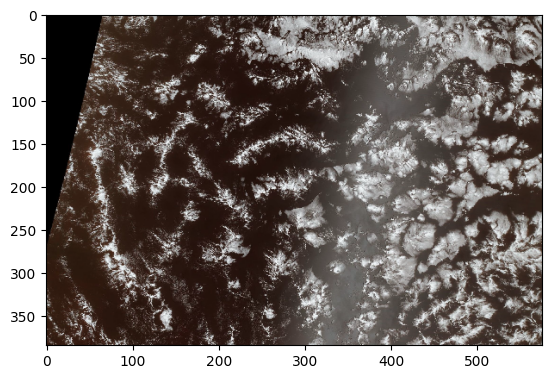

In [106]:
image = cv2.imread('/tf/understanding_cloud_organization/train_images/0011165.jpg')
image = cv2.resize(image, dsize = (576,384))
plt.imshow(image)
plt.show()

2. 이미지의 라벨을 불러온다.

라벨의 총 넓이는 86998입니다.


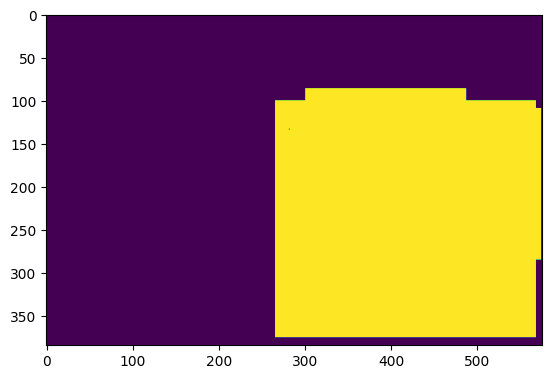

In [168]:
sub1 = rle2mask(train_df.iloc[1,1], input_shape = (1400, 2100))
sub1 = np_resize(sub1, (384, 576))
sub = np.stack((sub0,sub1,sub2,sub3), axis = -1)
print("라벨의 총 넓이는 {}입니다.".format(sub1.sum()))
plt.imshow(sub1)
plt.show()

2. 이미지의 예측값을 본다. 

In [108]:
image = np.expand_dims(image, axis=0)
predicted_label = model.predict(image)
predicted_label.shape

1/1 [==============================] - 0s 17ms/step


(1, 384, 576, 4)

예측값의 총 넓이는 541입니다. 


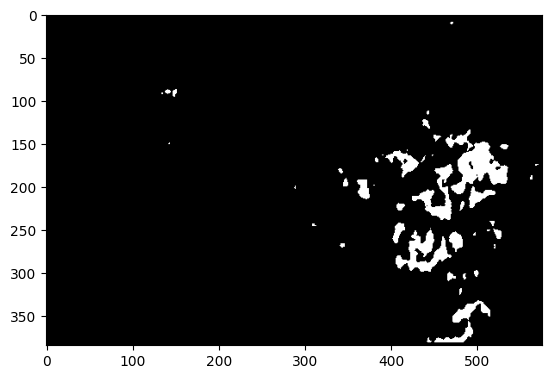

In [171]:
#predicted_label[0,:,:,0].shape
print("예측값의 총 넓이는 {}입니다. ".format((predicted_label[0,:,:,1]>0.5).sum()))
plt.imshow(predicted_label[0,:,:,1] > 0.2, cmap = 'gray')
plt.show()

구름의 결과값이 Scatter되어있기 때문에, Post-process stage에서 Convex Hull Algorithm을 적용하면 성능이 향상될 것으로 예측됩니다.

컨벡스Hull 적용한 예측값의 총 넓이는 541입니다. 참고로 이건 (label데이터가 있는) training dataset에 대해서 조사한거고 하나만 본거라... 정확하진 않음 오버피팅 문제가 있을수도 있음을 명시하시오.


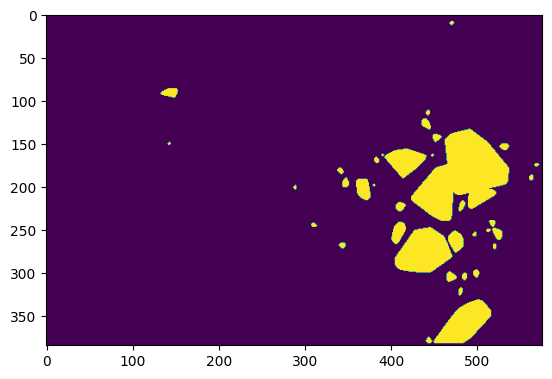

In [192]:
cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
rect = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
img = (predicted_label[0,:,:,1] > 0.2).astype('float32')
#dil = cv2.dilate(img, cross, iterations=10)
con = draw_convex_hull(dil.astype(np.uint8), mode='convex')
print("컨벡스Hull 적용한 예측값의 총 넓이는 {}입니다. 참고로 이건 (label데이터가 있는) training dataset에 대해서 조사한거고 하나만 본거라... 정확하진 않음 오버피팅 문제가 있을수도 있음을 명시하시오.".format((predicted_label[0,:,:,1]>0.5).sum()))
plt.imshow(con)
plt.show()

--> Convex Hull 이후의 성능 개선이 미미한 이유는, 라벨의 이미지가 큰 사각형이라는 점을 이용할 수 없기 때문이라고 판단하였음. 때문에 Convex Hull 알고리즘의 대안으로, 위와 비슷한 이미지를 생성해낸 후, 이를 사각형의 큰 라벨로 바꾸는 모델을 학습시켜 Post-process에도 딥러닝을 적용시키는 방안에 대해 생각함.

## Idea: Self-Supervised Learning Methods를 통한 Label에 대한 Post-processing

### Label에서 0.999%를 제거합니다.

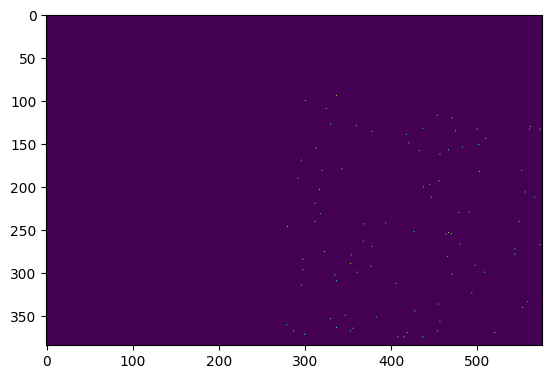

In [196]:
cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
rect = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
modified_label = (np.multiply(sub1, np.random.random_sample((384,576))) > 0.999).astype('uint8')
plt.imshow(modified_label)
plt.show()

 Morphological dilation을 통해 원본을 복구함.

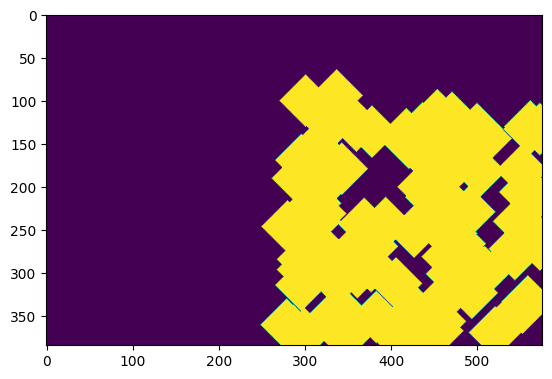

In [197]:
modified_label = cv2.dilate(modified_label, cross, iterations=30)
plt.imshow(modified_label)
plt.show()

Convex-Hull을 적용시키면 아래와 같은 사진이 등장함.

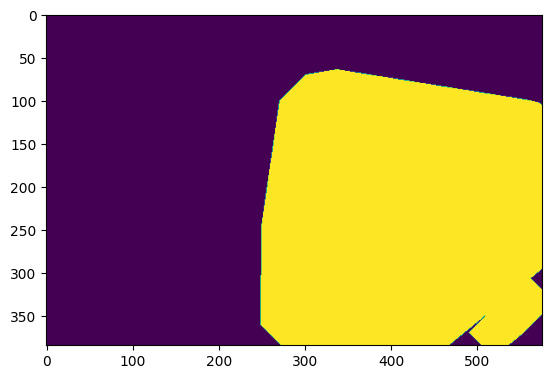

In [198]:
modified_label = draw_convex_hull(modified_label, mode='convex')
plt.imshow(modified_label)
plt.show()

## Evaluation

In [111]:
hist_df = pd.DataFrame(history.history) 

In [118]:
hist_df.max()

loss             0.508718
dice_coef        0.623382
val_loss         0.727976
val_dice_coef    0.562098
lr               0.000500
dtype: float64

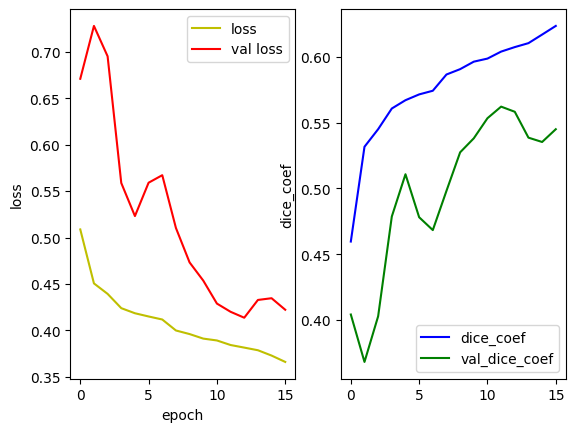

In [115]:
fig, loss_ax = plt.subplots(1,2)

loss_ax[0].plot(history.history['loss'], 'y', label='loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')
loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[0].legend(loc='upper right')

loss_ax[1].plot(history.history['dice_coef'], 'b', label='dice_coef')
loss_ax[1].plot(history.history['val_dice_coef'], 'g', label='val_dice_coef')
loss_ax[1].set_ylabel('dice_coef')
loss_ax[1].legend(loc='lower right')

plt.show()

## Predicting (using min_size post-processing)

In [ ]:
best_threshold = 0.5
best_size = 15000  # 이것도 hyper parameter라 우리가 직접 바꿔가면서 테스트해봐야됨.

In [ ]:
def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


In [ ]:
def post_process2(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    
    #num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    #predictions = np.zeros((350, 525), np.float32)
    #num = 0
    #for c in range(1, num_component):
        #p = (component == c)
        #if p.sum() > min_size:
            #predictions[p] = 1
            #num += 1
    return mask

In [ ]:
# sigmoid = lambda x: 1 / (1 + np.exp(-x))

Predict output shape is (320,480,4). 4 is classes(Fish, Flower, Gravel, Surger)

Using `pred_masks[...,k] ` or `pred_masks[:,:,k]` get one class of mask image.

In [ ]:
#model.load_weights('model.h5')
test_df = []
encoded_pixels = []
TEST_BATCH_SIZE = 500

for i in range(0, test_images.shape[0], TEST_BATCH_SIZE):
    batch_idx = list(
        range(i, min(test_images.shape[0], i + TEST_BATCH_SIZE))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_images,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(384, 576),
        n_channels=3,
        graystyle=False,
        base_path=Hymynameis+'/understanding_cloud_organization/test_images',
        target_df=submission_df,
        batch_size=1,
        n_classes=4
    )

    batch_pred_masks = model5.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    ) 
    # Predict out put shape is (384X576X4)
    # 4  = 4 classes, Fish, Flower, Gravel Surger.
    
    for j, idx in enumerate(batch_idx):
        filename = test_images['ImageId'].iloc[idx]
        image_df = submission_df[submission_df['ImageId'] == filename].copy()
        
        # Batch prediction result set
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        
        image_df['EncodedPixels'] = pred_rles
        
        test_df.append(image_df)
        
        
        for k in range(pred_masks.shape[-1]):
            pred_mask = pred_masks[...,k].astype('float32') 
            
            if pred_mask.shape != (350, 525):
                pred_mask = cv2.resize(pred_mask, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            
            pred_mask = post_process2(pred_mask, best_threshold, best_size ) #여기부터 수정
            
            r = mask2rle(pred_mask)
            encoded_pixels.append(r)
        """
        # pred_rles = build_rles(pred_masks, reshape=(350, 525))

            #image_df['EncodedPixels'] = encoded_pixels
            #test_df.append(image_df)
        """

In [ ]:
            pred_mask, num_predict = post_process(pred_mask, best_threshold, best_size ) #수정
            
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(pred_mask)
                encoded_pixels.append(r)

In [ ]:
submission_df['EncodedPixels'] = encoded_pixels
submission_df.head(20)

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

In [ ]:
submission_df.to_csv('submission_mobile_nopost.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

encoded_pixels

In [ ]:
#test_df = pd.concat(test_df)
#test_df.drop(columns='ImageId', inplace=True)
#test_df.to_csv('all_flower_submission.csv', index=False)

## Show segmentation masks (applying Convex-hull algorithm)

In [ ]:
sub = pd.read_csv("//drive/MyDrive/Colab Notebooks/submission_ensemble5_mobeffihrnet.csv")

In [ ]:
sub['ImageId'] = sub['Image_Label'].apply(lambda x : x.split('_')[0])
sub.head()

In [ ]:
import random

test_images_ids = random.sample(list(sub['ImageId'].unique()), 2)
test_images_ids

In [ ]:
#test_images_ids = ['0038327.jpg', '004f759.jpg']

In [ ]:
def make_mask(df, image_label, cv_shape = (350, 525),debug=False):
    """
    Create mask based on df, image name and shape.
    """
    if debug:
        print(cv_shape)
    df = df.set_index('Image_Label')
    encoded_mask = df.loc[image_label, 'EncodedPixels']
#     print('encode: ',encoded_mask[:10])
    mask = np.zeros((350, 525), dtype=np.float32)
    if encoded_mask is not np.nan:
        mask = rle2mask(encoded_mask,cv_shape) # original size
            
    return mask

In [ ]:
def show_image(image,figsize=None,title=None):
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
#     else: # crash!!
#         fig = plt.figure()
        
    if image.ndim == 2:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)
        
    if title is not None:
        plt.title(title)
        
def show_Nimages(imgs,scale=1):

    N=len(imgs)
    fig = plt.figure(figsize=(25/scale, 16/scale))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1, N, i + 1, xticks=[], yticks=[])
        show_image(img)
    plt.show()

def draw_masks(img2,img_mask_list):
    
    img = img2.copy()
    for ii in range(4): # for each of the 4 masks
        color_mask = np.zeros(img2.shape)
        temp_mask = np.ones([img2.shape[0],img2.shape[1]])*127./255.
        temp_mask[img_mask_list[ii] == 0] = 0
        if ii < 3: # use different color for each mask
            color_mask[:,:,ii] = temp_mask
        else:
            color_mask[:,:,0],color_mask[:,:,1],color_mask[:,:,2] = temp_mask,temp_mask,temp_mask # broadcasting to 3 channels
    
        img += color_mask
        
    return img

In [ ]:
def draw_convex_hull(mask, mode='convex'):
    
    img = np.zeros(mask.shape)
    contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        if mode=='rect': # simple rectangle
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), -1)
        elif mode=='convex': # minimum convex hull
            hull = cv2.convexHull(c)
            cv2.drawContours(img, [hull], 0, (255, 255, 255),-1)
        elif mode=='approx':
            epsilon = 0.02*cv2.arcLength(c,True)
            approx = cv2.approxPolyDP(c,epsilon,True)
            cv2.drawContours(img, [approx], 0, (255, 255, 255),-1)
        else: # minimum area rectangle
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, (255, 255, 255),-1)
    return img/255.

In [ ]:
mode='convex' # choose from 'rect', 'min', 'convex' and 'approx'

class_names = ['Fish', 'Flower', 'Gravel', 'Sugar']
test_imgs_folder = Hymynameis+'/understanding_cloud_organization/test_images'
NN=2
folder_images=test_imgs_folder
images_list = test_images_ids #os.listdir(folder_images)
current_batch = images_list[0: NN]
print(current_batch)

for i, image_name in enumerate(current_batch):
    path = os.path.join(folder_images, image_name)
    print(path)
    img = cv2.imread(path).astype(np.float32) # use already-resized ryches' dataset
    img = np_resize(img, (350, 525))
    print(img.max(), img.min())
    img = img/255.
    
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = np.stack([img2,img2,img2],axis=-1)
         
    img_mask=[]
    img_mask_convex=[]
    
    for class_id in range(4):
        img_mask.append(make_mask(sub, image_name + '_' + class_names[class_id],
                                  cv_shape = (350, 525)))
        print(img_mask[class_id].min(), img_mask[class_id].max())
        img_mask_convex.append(draw_convex_hull(img_mask[class_id].astype(np.uint8), mode=mode))
        img_mask_convex[class_id][img2[:,:,0]<=2/255.] = 0
    
    img3 = draw_masks(img2,img_mask)
    img4 = draw_masks(img2,img_mask_convex)
    show_Nimages([img2,img3,img4])
    show_Nimages(img_mask)
#     show_Nimages([img2]+img_mask_convex)
    show_Nimages(img_mask_convex)

## Final Prediction using convex hull
- 앙상블한 결과도 이 코드 적용시켜야됨.

In [ ]:
model_class_names=['Fish', 'Flower', 'Gravel', 'Sugar']
mode='convex' # choose from 'rect', 'min', 'convex' and 'approx'

img_label_list = []
enc_pixels_list = []
test_imgs = os.listdir(folder_images)
for test_img_i, test_img in enumerate(tqdm(test_imgs)):
    for class_i, class_name in enumerate(model_class_names):
        
        path = os.path.join(folder_images, test_img)
        img = cv2.imread(path).astype(np.float32)
        img = np_resize(img, (350, 525))
        img = img/255.
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        img_label_list.append(f'{test_img}_{class_name}')
        
        mask = make_mask(sub, test_img + '_' + class_name, cv_shape=(350,525))
        if True:
        #if class_name == 'Flower' or class_name =='Sugar': # you can decide to post-process for some certain classes 
            mask = draw_convex_hull(mask.astype(np.uint8), mode=mode)
        mask[img2<=2/255.] = 0
        mask, num_predict = post_process(mask, best_threshold, best_size)
        
        if mask.sum() == 0:
            enc_pixels_list.append('')
        else:
            enc_pixels_list.append(mask2rle(mask))
            
submission_df2 = pd.DataFrame({'Image_Label': img_label_list, 'EncodedPixels': enc_pixels_list})

In [ ]:
submission_df2.sort_values(by='Image_Label').head(20)

- check if it has been processed correctly

In [ ]:
submission_df2['ImageId'] = submission_df2['Image_Label'].apply(lambda x : x.split('_')[0])

In [ ]:
test_images_ids = random.sample(list(submission_df2['ImageId'].unique()), 2)
test_images_ids

In [ ]:
# test_images_ids = ['0038327.jpg', '004f759.jpg']

In [ ]:
mode='convex' # choose from 'rect', 'min', 'convex' and 'approx'

class_names = ['Fish', 'Flower', 'Gravel', 'Sugar']
test_imgs_folder = Hymynameis+'/understanding_cloud_organization/test_images'
NN=2
folder_images=test_imgs_folder
images_list = test_images_ids #os.listdir(folder_images)
current_batch = images_list[0: NN]
print(current_batch)

for i, image_name in enumerate(current_batch):
    path = os.path.join(folder_images, image_name)
    print(path)
    img = cv2.imread(path).astype(np.float32) # use already-resized ryches' dataset
    img = np_resize(img, (350, 525))
    print(img.max(), img.min())
    img = img/255.
    
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = np.stack([img2,img2,img2],axis=-1)
    
    mode='convex'
    img_mask=[]
    img_mask_convex=[]
    for class_id in range(4):
        img_mask.append(make_mask(submission_df2, image_name + '_' + class_names[class_id],
                                  cv_shape = (350, 525)))
        img_mask_convex.append(draw_convex_hull(img_mask[class_id].astype(np.uint8), mode=mode))
        img_mask_convex[class_id][img2[:,:,0]<=2/255.] = 0


- final output

In [ ]:
submission_df2.sort_values(by='Image_Label').to_csv('submission_ensemble5_convex.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

## Ensemble

In [ ]:
# hrnet : private 0.63032
model1 = tf.keras.models.load_model(Hymynameis+'/understanding_cloud_organization/hrnet.h5', custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef' : dice_coef})
# efficientnetb1 + unet : private 0.64324
model2 = tf.keras.models.load_model(Hymynameis+'/understanding_cloud_organization/effb1unet.h5', compile=False)
# resnet50 + deeplabv3+ : private 0.5792
model3 = tf.keras.models.load_model(Hymynameis+'/understanding_cloud_organization/deeplab.h5', custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef' : dice_coef})

In [ ]:
#model.load_weights('model.h5')
test_df = []
encoded_pixels = []
TEST_BATCH_SIZE = 500

for i in range(0, test_images.shape[0], TEST_BATCH_SIZE):
    batch_idx = list(
        range(i, min(test_images.shape[0], i + TEST_BATCH_SIZE))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_images,
        shuffle=False,
        mode='predict',
        dim=(350, 525),
        reshape=(384, 576),
        n_channels=3,
        graystyle=False,
        base_path=Hymynameis+'/understanding_cloud_organization/test_images',
        target_df=submission_df,
        batch_size=1,
        n_classes=4
    )

    batch_pred_mask1 = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    ) 

    batch_pred_mask2 = model3.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    )

    batch_pred_mask3 = model5.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    ) 

    batch_pred_masks = (batch_pred_mask1 + batch_pred_mask2 + batch_pred_mask3) / 3

    # Predict out put shape is (384X576X4)
    # 4  = 4 classes, Fish, Flower, Gravel Surger.
    
    for j, idx in enumerate(batch_idx):
        filename = test_images['ImageId'].iloc[idx]
        image_df = submission_df[submission_df['ImageId'] == filename].copy()
        
        # Batch prediction result set
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        
        image_df['EncodedPixels'] = pred_rles
        
        test_df.append(image_df)
        
        
        for k in range(pred_masks.shape[-1]):
            pred_mask = pred_masks[...,k].astype('float32') 
            
            if pred_mask.shape != (350, 525):
                pred_mask = cv2.resize(pred_mask, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            
            pred_mask, num_predict = post_process(pred_mask, best_threshold, best_size )
            
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(pred_mask)
                encoded_pixels.append(r)
        """
        # pred_rles = build_rles(pred_masks, reshape=(350, 525))

            #image_df['EncodedPixels'] = encoded_pixels
            #test_df.append(image_df)
        """

In [ ]:
submission_df['EncodedPixels'] = encoded_pixels
submission_df.head(20)

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

In [ ]:
submission_df.to_csv('submission_ensemble5_mobeffihrnet.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

- [Ensemble 1]
-
- Model : (EfficientNetB1 + Unet) + (HRNetV2)
- Method : Average; (fitted value of Unet + fitted value of HRNet) / 2 ---> soft voting??
- Score : 0.64625 (private), 0.652 (public)
- Applying convex hull : 0.64699 (private), 0.65268 (public)
- Rank : #338 (private)

- [Ensemble 2]
-
- Model : (EfficientNetB1 + Unet) + (HRNetV2) + (Resnet50 + DeeplabV3+)
- Method : Average ---> soft voting??
- Score : 0.63954 (private), 0.64481 (public)
- Applying convex hull : 0.64052 (private), 0.64564 (public)

## Check the classification results

In [ ]:
#hrnet
sub1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/submission_notsig.csv")
#efficientnetb1 + unet
sub2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/submission_effiunet_area.csv")
#resnet50 + deeplabv3+
sub3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/submission_deeplabv3_unmask.csv")

In [ ]:
sub1.head()

In [ ]:
data = [sub1, sub2, sub3]

for d in data :
  d['Label'] = d['Image_Label'].str.split("_", n = 1, expand = True)[1]
  d['Image'] = d['Image_Label'].str.split("_", n = 1, expand = True)[0]
  
  print("Results: ")
  print(d[(d.Label == 'Fish')&(d.EncodedPixels.notnull())]['Image'].count())
  print(d[(d.Label == 'Sugar')&(d.EncodedPixels.notnull())]['Image'].count())
  print(d[(d.Label == 'Gravel')&(d.EncodedPixels.notnull())]['Image'].count())
  print(d[(d.Label == 'Flower')&(d.EncodedPixels.notnull())]['Image'].count())
  print("\n")